### 1. 패키지 불러오기 + 준비한 이미지 읽기

In [9]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [8]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sample.jpg'
img_orig = cv2.imread(img_path)
print(img_orig.shape)

(810, 670, 3)


### 2. DeepLab 모델

In [10]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

#### tar file에서 읽어들인 그래프 구조 graph_def를 불러 활용한다.

In [13]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

#### 사전에 학습된 가중치 불러오기

In [15]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


#### 1.에서 준비한 이미지를 네트워크에 입력한다.

In [18]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(810, 670, 3) (513, 424, 3) 15


In [19]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

라벨에서 person라벨, 즉 15를 가진 영역만 검출해 내고 싶다.
### 3. 마스크 만들기 및 시각화

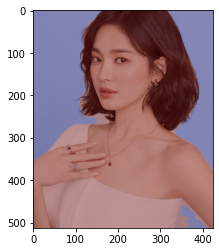

In [21]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max()) #255로 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 4. Segmentation 결과를 원래 크기로 복원한다.

DeepLab모델을 사용하기 위해 이미지를 resize했다.
이 resize한 이미지를 다시 원래 크기로 복원한다.
이 때, cv2.resize()함수를 이용한다.
img_mask_up은 경계가 블러된 픽셀값 0~255의 이미지를 얻는다.

확실한 경계를 얻기 위해, 128을 기준으로 임계값 threshold를 설정한다.
128이하의 값은 = 0, 128 이상의 값은 255로 만드는 방식이다.

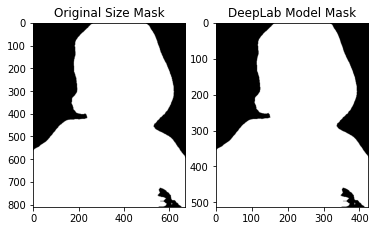

In [22]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 5. 배경 흐리게 하기 - blur()

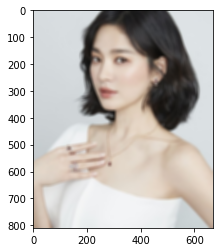

In [25]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

이 흐려진 이미지에서 앞서 만든 segmentation mask를 이용해 배경만 추출한다.

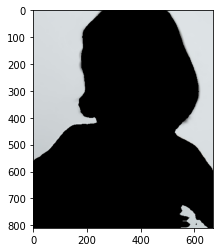

In [28]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 6. 흐린 배경 + 원본 합성

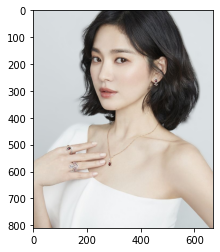

In [29]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 1-2. 고양이 사진

In [39]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'
img_orig = cv2.imread(img_path)
print(img_orig.shape)

(620, 620, 3)


In [40]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(620, 620, 3) (513, 513, 3) 8


In [41]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

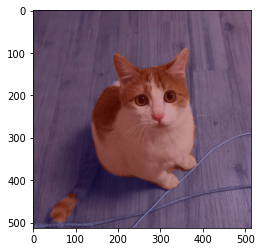

In [42]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)
img_mask = seg_map * (255/seg_map.max()) #255로 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

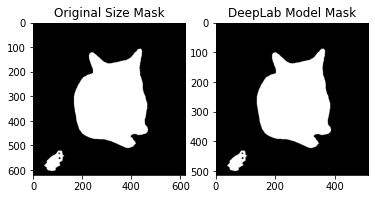

In [43]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

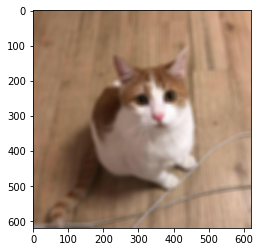

In [44]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

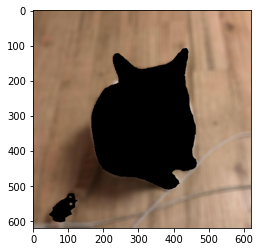

In [45]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

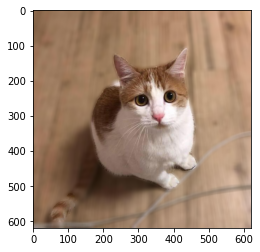

In [46]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### Q. 여기서 발생하는 문제점?

첫번째 인물 사진에서 보면, 머리카락과 인물의 경계가 정확하게 잡히지 않는 것을 볼 수 있다.
명확하지 않은 경계 때문에 머리카락부터 몸체까지 하나로 인식되어 버린다.
이와 반대로, 고양이에서는 몸체와 꼬리가 하나로 인식되는 것이 필요하다.
하지만, 연결되지 않고, 각각 따로 인식이 되는 것을 확인할 수 있다.


### Q. 해결방안?

앞서 경계를 설정 할 때, 확실한 경계를 설정하기 위해 128(중앙값)을 threshold로 선정하여 구분 지었다. 사실, 128이라는 경계가 중앙값이 어떠한 이유로 채택 된것인가에 대해서는 아직 정확하게 이해하지 못했다. 하지만, 이러한 원리를 이용하여, 위에서 언급한 문제들 또한 유사하게 해결할 수 있을것 같아 2가지를 고안해 보았다.

1. 머신러닝의 K-neighbor classification을 통해서 해결할 수 있을 것이다.
   몸체의 특정 영역에 있는 색깔들과 배경에 있는 색깔들을 추출하고, 추출된 색깔들의 변화가 나타나면 그부분을 기준으로 몸체와 배경의 경계를 선정한다.
   
2. 머리카락의 영역와 머리카락이 아닌 영역의 색상은 다르다. 마찬가지로, 꼬리와 꼬리가 아닌 배경의 부분은 색이 다르다.
머리카락의 RGB가 다른 영역과 다르다면, 그 영역이 머리카락의 영역에서 벗어났다고 파악할 것이고 이러한 변화가 급격하게 나타나는 부분들을 중심으로 연결하여 경계를 설정할 수 있을 것이다.